Приложение №1: основной код с комментариями, выполнено в Питоне

Прежде чем начать прогнозирование, загрузим все необходимые пакеты, главные из них: math и numpy для вычисления метрик качества и работы с формулами, pd для работы с массивами датасетов, plt для построения графиков, statsmodels для использования основных статистических моделей.

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats
from __future__ import division, print_function
import statsmodels as sm

from collections import defaultdict
from math import log
from numpy import hstack, vstack
from numpy.linalg import inv, svd

from statsmodels.compat.python import range, string_types, iteritems
from statsmodels.iolib.summary import Summary
from statsmodels.iolib.table import SimpleTable
from statsmodels.tools.decorators import cache_readonly
from statsmodels.tools.sm_exceptions import HypothesisTestWarning
from statsmodels.tools.tools import chain_dot
from statsmodels.tsa.tsatools import duplication_matrix, vec

import statsmodels.tsa.base.tsa_model as tsbase
import statsmodels.tsa.vector_ar.irf as irf
import statsmodels.tsa.vector_ar.plotting as plot
from statsmodels.tsa.vector_ar.var_model import forecast, VAR, ma_rep, _compute_acov

mdata = sm.datasets.macrodata.load().data
mdata = mdata[['realgdp','realcons','realinv']]
names = mdata.dtype.names
data = mdata.view((float,3))
data = np.diff(np.log(data), axis=0)

In [3]:
newdata = pd.DataFrame(mdata)
newdata[:8]

,realgdp,realcons,realinv
0,2710.349,1707.4,286.898
1,2778.801,1733.7,310.859
2,2775.488,1751.8,289.226
3,2785.204,1753.7,299.356
4,2847.699,1770.5,331.722
5,2834.390,1792.9,298.152
6,2839.022,1785.8,296.375
7,2802.616,1788.2,259.764


Мы загрузили датасет, который зашит в статистическом пакете python-statsmodels.

Как мы видим, наш временной ряд включает в себя динамику трех переменных - реального ВВП, реального потребления и реальных инвестиций, данные собраны годовые и более чем за 200 лет.

In [4]:
len(newdata)

203

In [5]:
date = pd.date_range('1814-01-01', end = '2016-01-01', freq = 'AS')
newdata.index = date

In [6]:
newdata[:8]

,realgdp,realcons,realinv
1814-01-01,2710.349,1707.4,286.898
1815-01-01,2778.801,1733.7,310.859
1816-01-01,2775.488,1751.8,289.226
1817-01-01,2785.204,1753.7,299.356
1818-01-01,2847.699,1770.5,331.722
1819-01-01,2834.390,1792.9,298.152
1820-01-01,2839.022,1785.8,296.375
1821-01-01,2802.616,1788.2,259.764


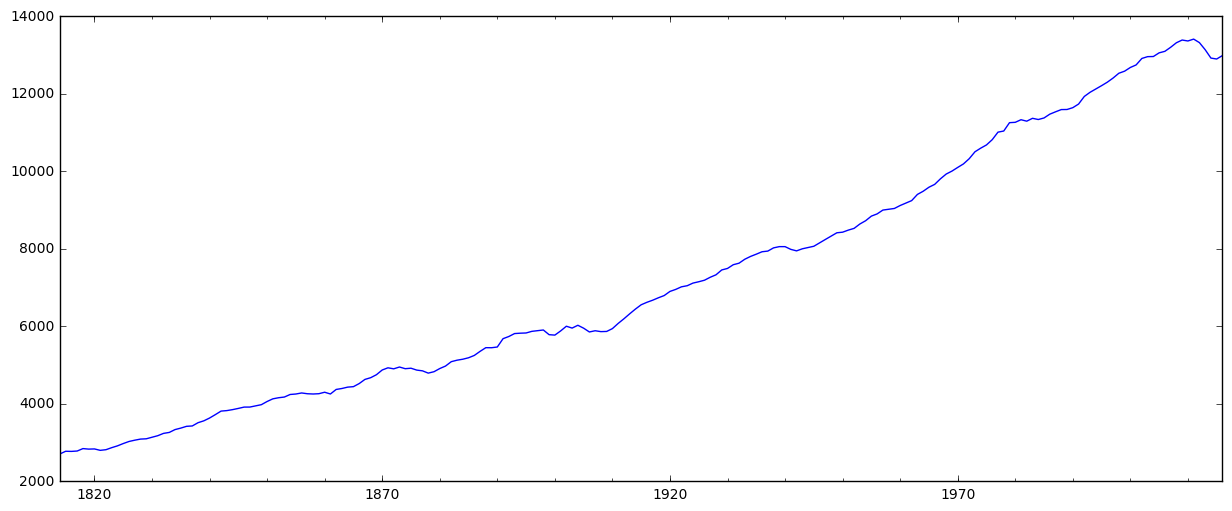

In [7]:
real_GDP = newdata['realgdp']
real_GDP.plot(figsize=(15, 6))
plt.show()

In [8]:
import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from tqdm import tqdm

Начнем моделирование с предположения — "завтра будет, как вчера", но вместо модели вида 
y(t)=y(t-1)
 будем считать, что будущее значение переменной зависит от среднего 
n
 её предыдущих значений, а значит, воспользуемся скользящей средней.

In [9]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(real_GDP, 24)
# прогноз по последним 24 наблюдениям

12859.946249999999

К сожалению, такой прогноз долгосрочным сделать не удастся — для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение — сглаживание исходного ряда для выявления трендов. В пакете pandas есть готовая реализация — DataFrame.rolling(window).mean(). Чем больше зададим ширину интервала — тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь с определением общих взавимосвязей.

In [10]:
def plotMovingAverage(series, n):

    rolling_mean = series.rolling(window=n).mean()

    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    
    plt.plot(real_GDP[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Для нашего ряда тренды и так вполне очевидны, причем в агрегированном смысле тяжело задать длину интервала, который бы представлял собой цикл активности, или экономический цикл, если бы данные были по какой-то определенной стране в определенный период, мы могли бы попробовать поставить активность в зависимость от срока нахождения на посту президента или, к примеру, пятилетних планов по развитию определенной отрасли или даже всех отраслей сразу.


Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в сумме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес.

In [12]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(real_GDP, [0.6, 0.2, 0.1, 0.07, 0.03])

13208.500510000002

# Экспоненциальное сглаживание, модель Хольта-Винтерса

Простое экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних 
n
 значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого экспоненциального сглаживания
 Экспоненциальность скрывается в рекурсивности функции — каждый раз мы умножаем 
1-
α
на предыдущее модельное значение, которое, в свою очередь, также содержало в себе 
1-
α
, и так до самого начала.

In [13]:

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

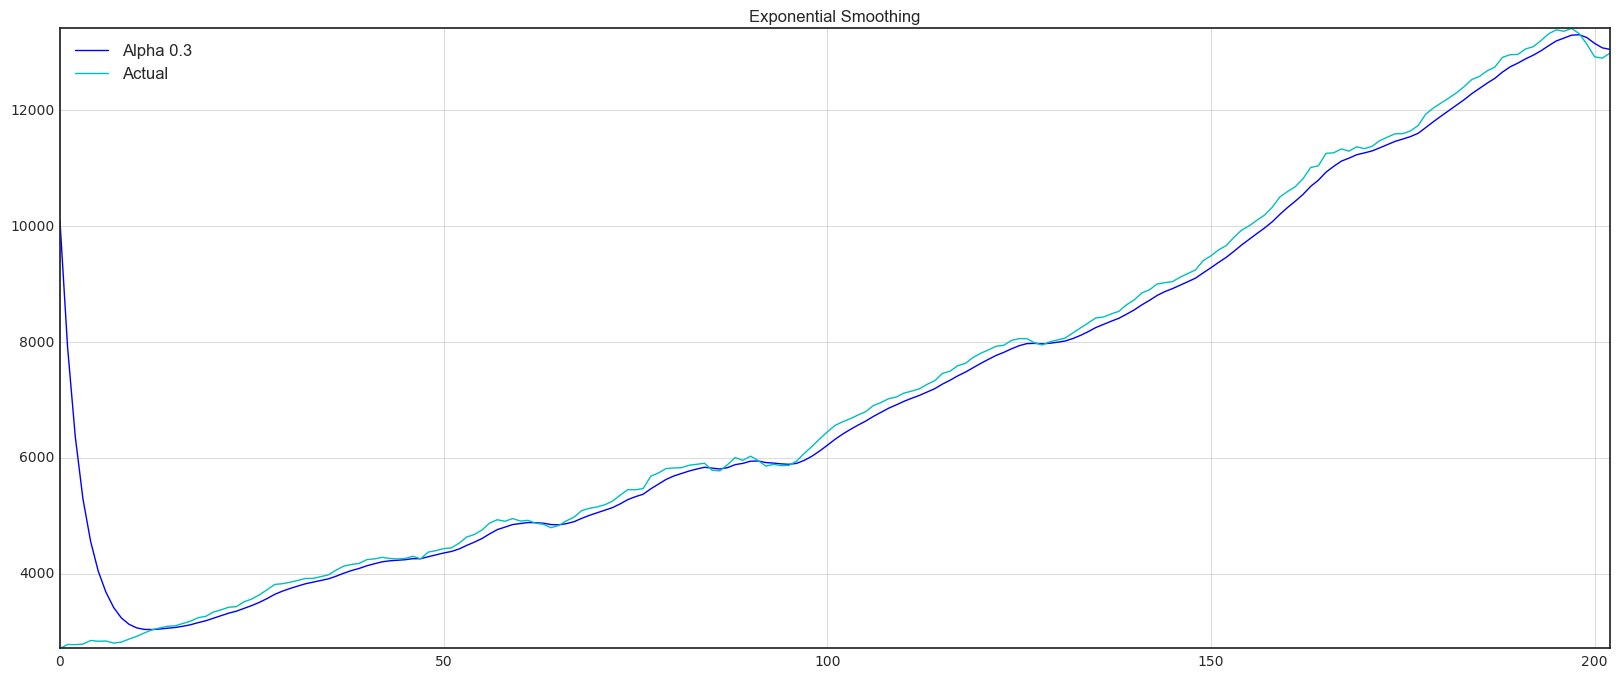

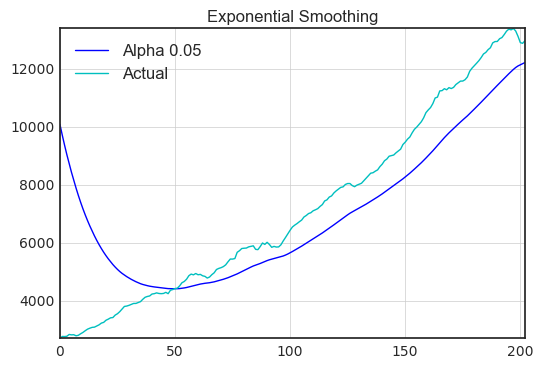

In [14]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(real_GDP, alpha), label="Alpha {}".format(alpha))
        plt.plot(real_GDP.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)
        plt.show()

# Двойное экспоненциальное сглаживание
До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз на  значения.

В этом нам поможет разбиение ряда на две составляющие — уровень (level, intercept) 
ℓ
 и тренд 
b
 (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

In [15]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

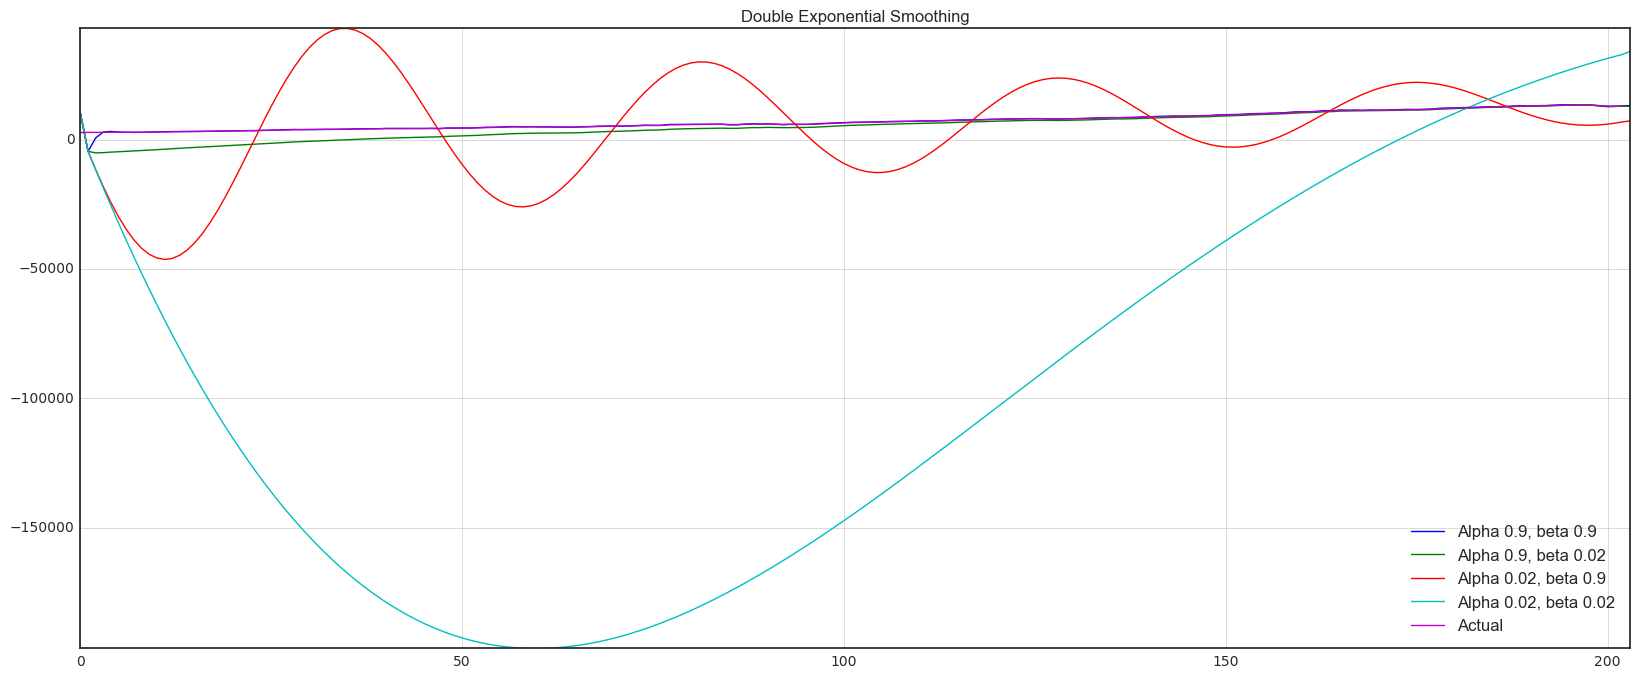

In [16]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(real_GDP, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(real_GDP.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    plt.show()

Теперь настраивать необходимо уже два параметра — α и β. Первый отвечает за сглаживание ряда вокруг тренда, второй — за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. А о не ручном подборе параметров расскажу чуть ниже, сразу после тройного экспоненциального сглаживания.

# Тройное экспоненциальное сглаживание Holt-Winters


Идея этого метода заключается в добавлении еще одной, третьей, компоненты — сезонности. Соответственно, метод применим только в случае, если ряд этой сезонностью не обделён, что в нашем случае верно. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона — периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, то и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать здесь. Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные 
m шагов вперёд, что не может не радовать.

In [17]:
class HoltWinters:

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

Кросс-валидация на временных рядах, подбор параметров

Перед тем, как построить модель, поговорим, наконец, о не ручной оценке параметров для моделей.

Ничего необычного здесь нет, по-прежнему сначала необходимо выбрать подходящуюю для данной задачи функцию потерь: RMSE, MAE, MAPE и др., которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и бодро опускаться в сторону глобального минимума ошибки.

Небольшая загвоздка возникает только в кросс-валидации. Проблема состоит в том, что временной ряд имеет, как ни парадоксально, временную структуру, и случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать чуть более хитрый способ для оптимизации параметров, официального названия которому я так и не нашел, но на сайте CrossValidated, где можно найти ответы на всё, кроме главного вопроса Жизни, Вселенной и Всего Остального, предлагают название "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста — начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого 
t
, делаем прогноз на 
t+
n
 шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до 
t+
n
 значения и прогнозируем с 
t+
n
 до 
t+
2
n
, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько 
n
 уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

In [18]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        #model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model = HoltWinters(series=values[train], slen = 1, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих параметров — каждый из них может принимать значения от 0 до 1, поэтому для минимизации функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном случае — Truncated Newton conjugate gradient.

In [19]:
%%time
data = real_GDP[:-50] # отложим часть данных для тестирования
from scipy.optimize import minimize
# инициализируем значения параметров

x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.330847303068 0.110770471072 0.148634920095
CPU times: user 955 ms, sys: 14.7 ms, total: 970 ms
Wall time: 963 ms


Передадим полученные оптимальные значения коэффициентов 
α
, 
β
 и 
γ
 и построим прогноз на 5 дней вперёд (128 часов)

In [20]:
# Передаем оптимальные значения модели
data = real_GDP
model = HoltWinters(data[:-50], slen = 1, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 50, scaling_factor = 2.56)
model.triple_exponential_smoothing()

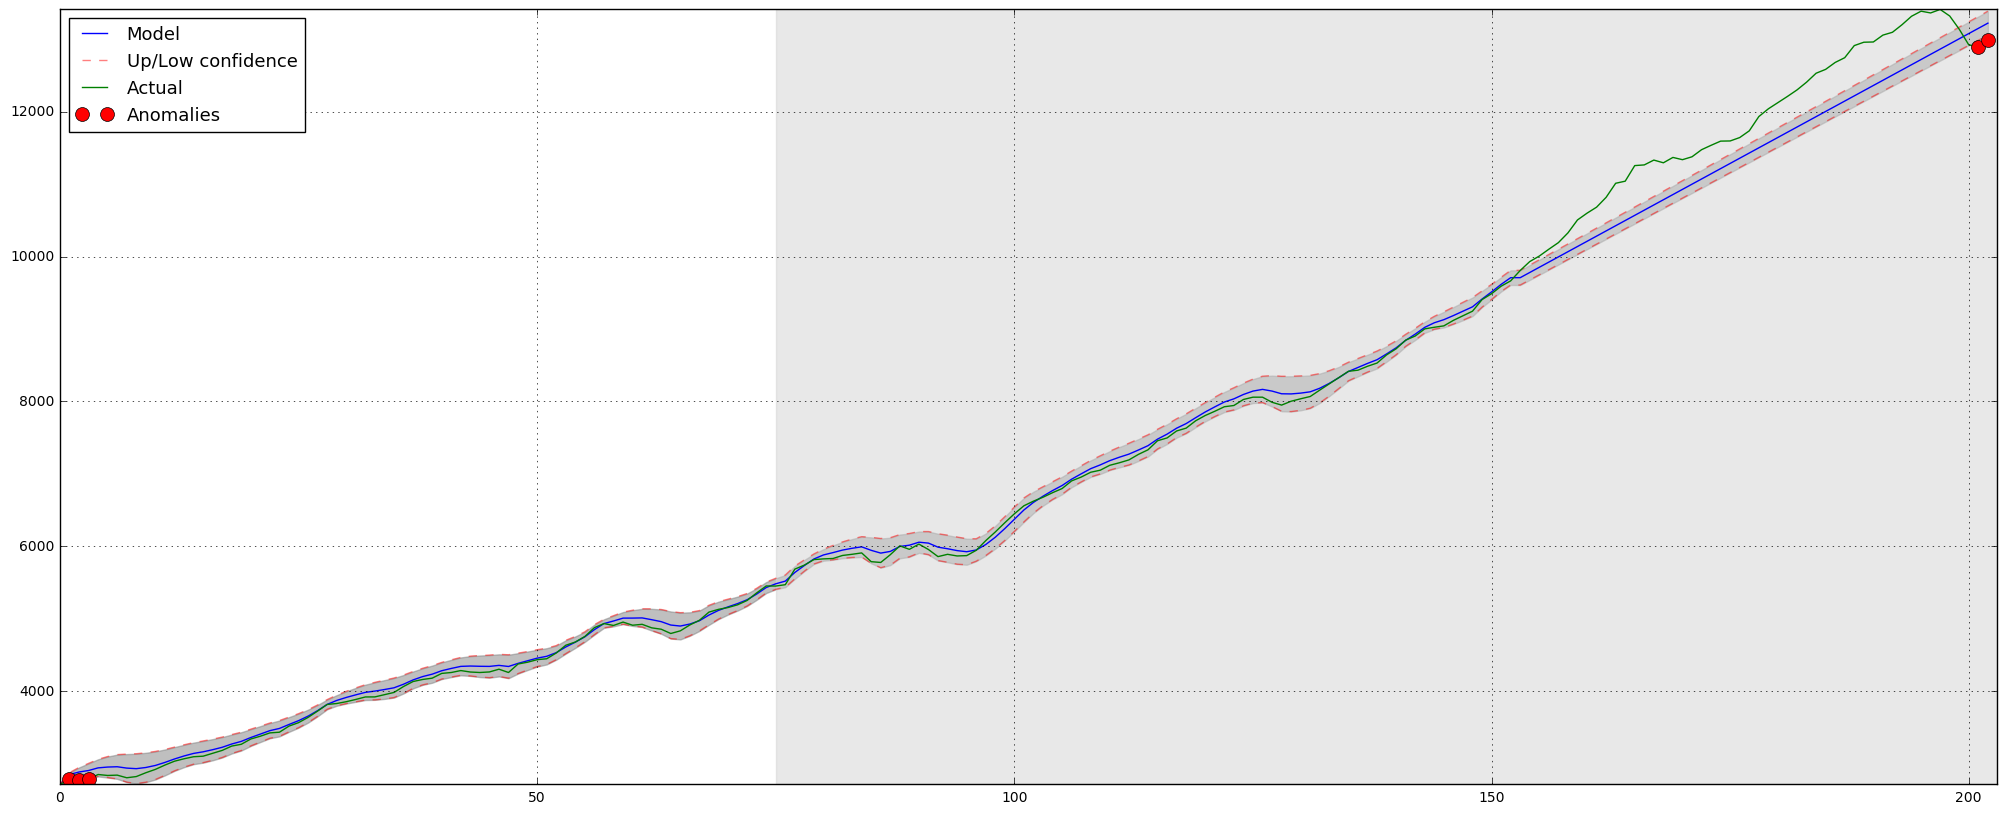

In [21]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()
plt.show()

Судя по графику, модель неплохо описала исходный временной ряд. Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах. Видно, что, научившись на прошлых наблюдениях, модель скопировала тренд, и прогнозы легли в рамках данного тренда, хотя и произошло упрощение зависимости и это отразилось в простой прямой на отрезке прогнозирования. 

# Эконометрический подход

Стационарность, единичные корни

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как стационарность.
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же гомоскедастичность) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями).

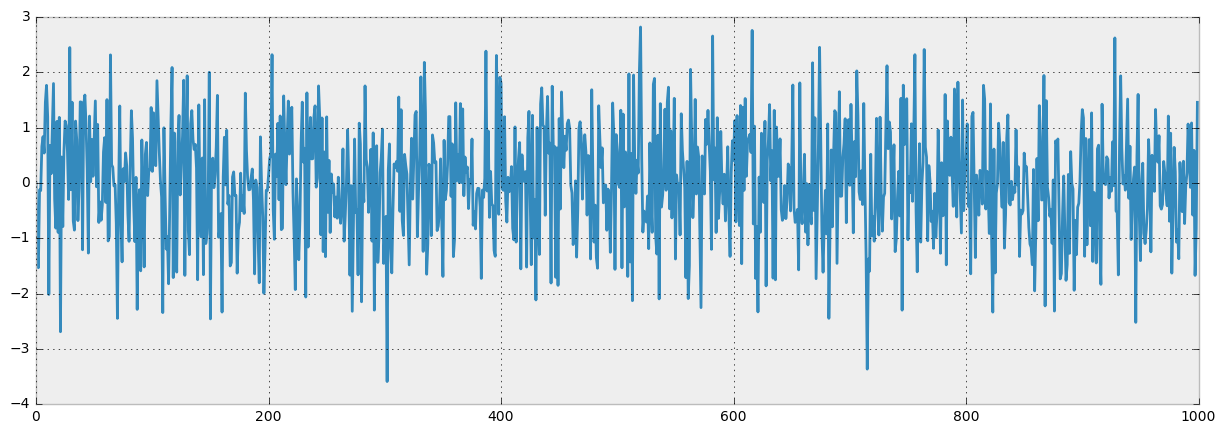

In [22]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)
    plt.show()

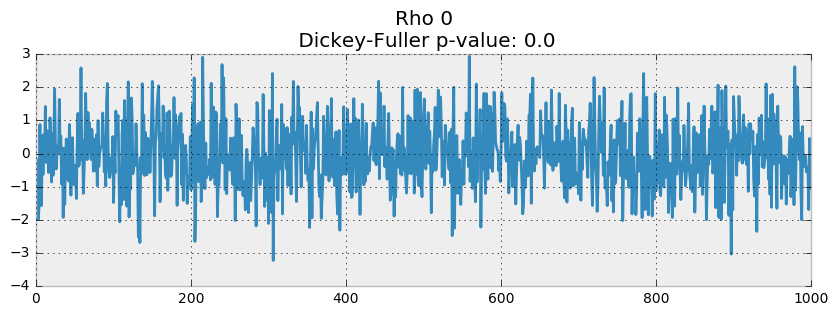

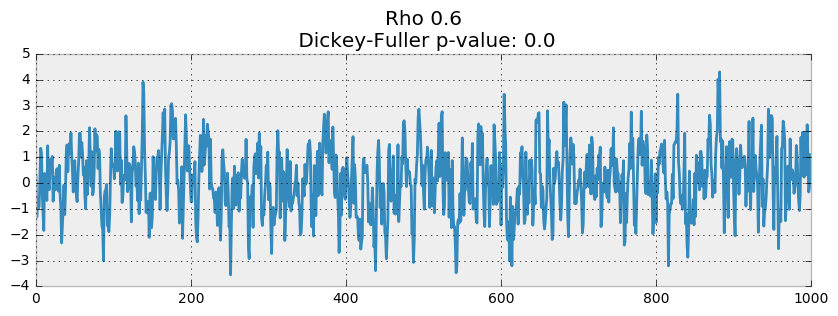

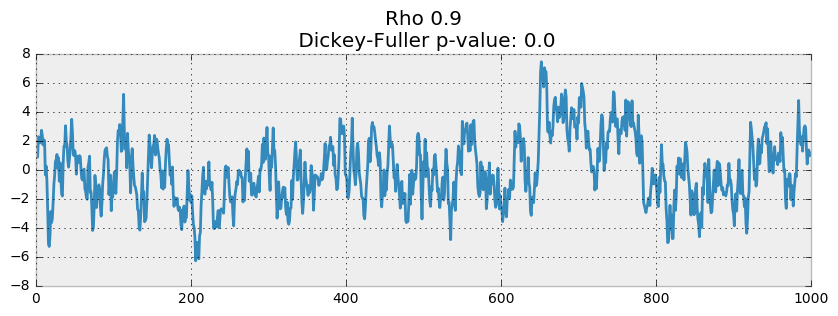

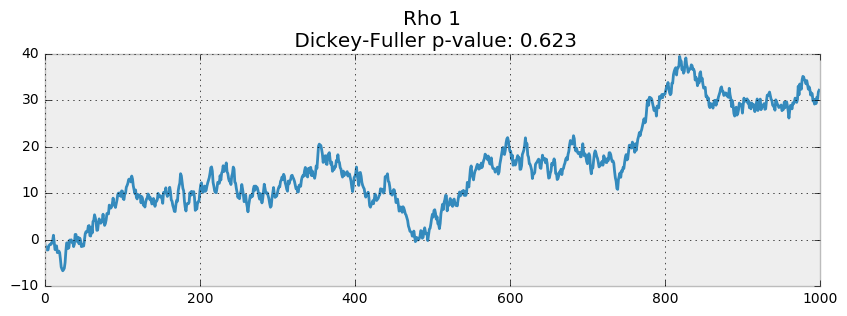

In [23]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)
    plt.show()


# SARIMA

SARIMA является разновидностью все той же ARIMA, только в ней снова реализуется попытка поймать сезонную компоненту, однако в нашем случае это работает не так эффективно по той причине, что данные по временном ряду выбраны ежегодные, и есть смысл думать об отсутствии сезонности.

Критерий Дики-Фуллера: p=0.998246


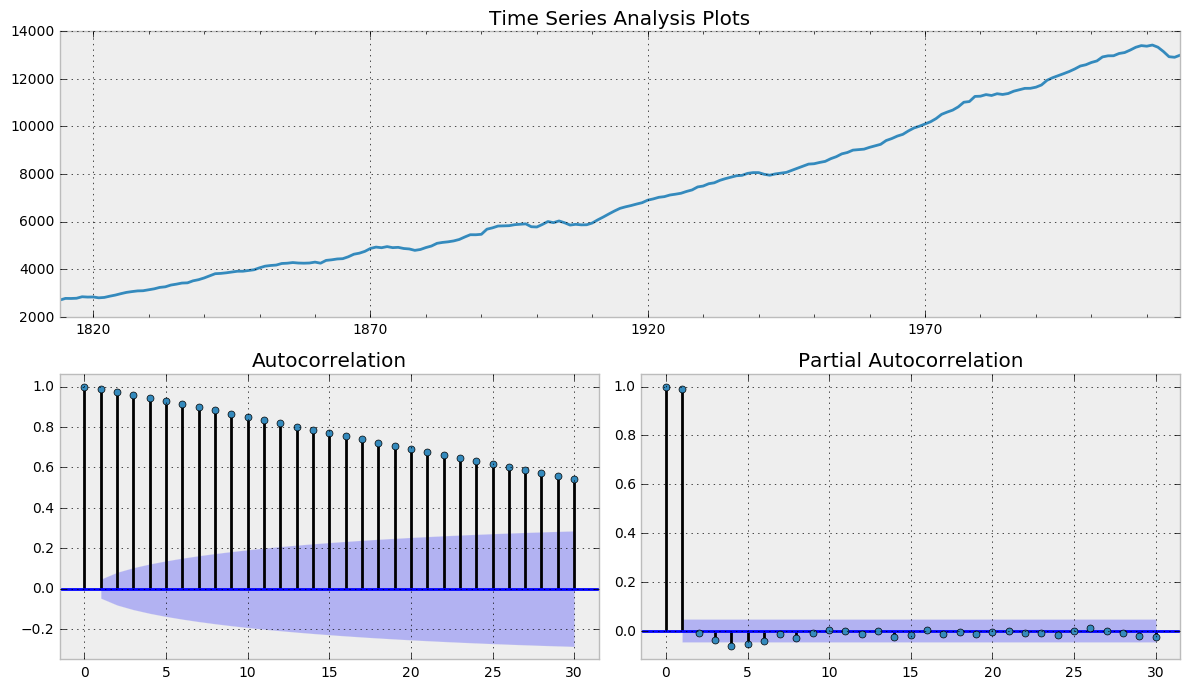

In [24]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(real_GDP, lags=30)
plt.show()

Критерий Дики-Фуллера: p=0.648612


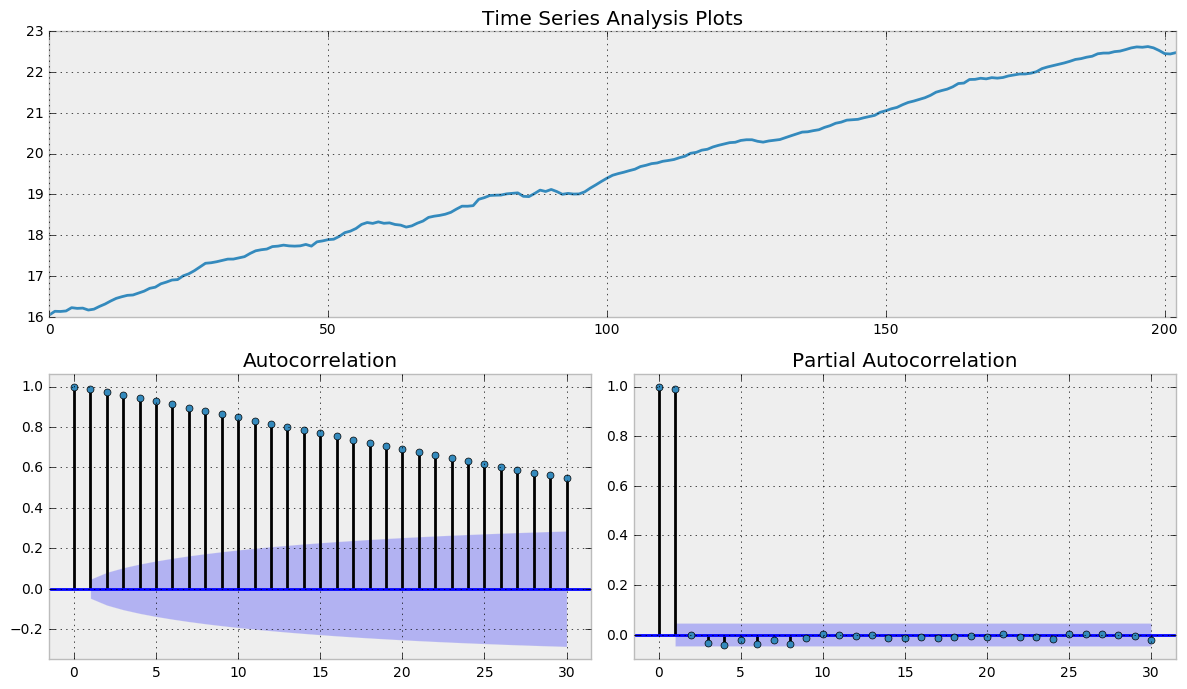

Оптимальный параметр преобразования Бокса-Кокса: 0.162072


In [25]:
# Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

GDP = real_GDP.copy()
GDP['GDP_box'], lmbda = scs.boxcox(real_GDP + 1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(GDP.GDP_box, lags=30)
plt.show()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

А теперь попробуем взять не стабилизирование дисперсии, так как по природе наш ряд не зашумленный и неамплитудный, но при этом имее постоянную тенденцию к росту

In [33]:
returns = (real_GDP.apply(pd.to_numeric, errors='coerce').pct_change()).dropna()
tsplot(returns, lags=30)

Критерий Дики-Фуллера: p=0.000000


Теперь гипотеза о нестационарности ряда отвергается, значит именно это преобразование было необходимо, и мы можем двигаться дальше, можно даже взять не темпы прироста, а абсолютные разности.

#  AR;  MA;  ARMA

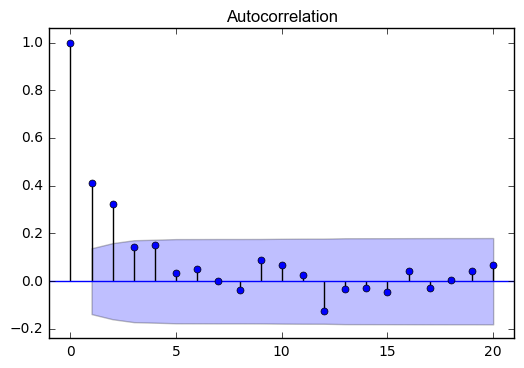

In [29]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


chg_temp = (real_GDP.diff()).dropna()

plot_acf(chg_temp, lags=20)
plt.show()

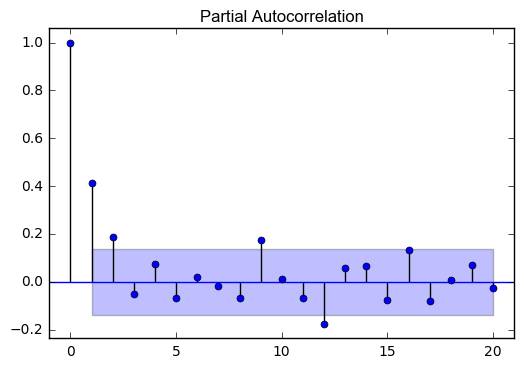

In [30]:
plot_pacf(chg_temp, lags=20)
plt.show()

In [31]:

from statsmodels.tsa.arima_model import ARMA


mod = ARMA(chg_temp, order=(1,0))
res = mod.fit()
print("The AIC for an AR(1) is: ", res.aic)


mod = ARMA(chg_temp, order=(2,0))
res = mod.fit()
print("The AIC for an AR(2) is: ", res.aic)


mod = ARMA(chg_temp, order=(0,1))
res = mod.fit()
print("The AIC for an MA(1) is: ", res.aic)


mod = ARMA(chg_temp, order=(1,1))
res = mod.fit()
print("The AIC for an ARMA(1,1) is: ", res.aic)

#AR(2) и ARMA(1,1) обладают наименьщими метриками AIC, 
#то есть проявляют себя лучше чем альтернативные им варианты

The AIC for an AR(1) is:  2195.2085071557376
The AIC for an AR(2) is:  2190.195344961745
The AIC for an MA(1) is:  2207.9569949823863
The AIC for an ARMA(1,1) is:  2191.7911407906513


лучше всего себя проявила авторегрессия 2 порядка.

# ARIMA

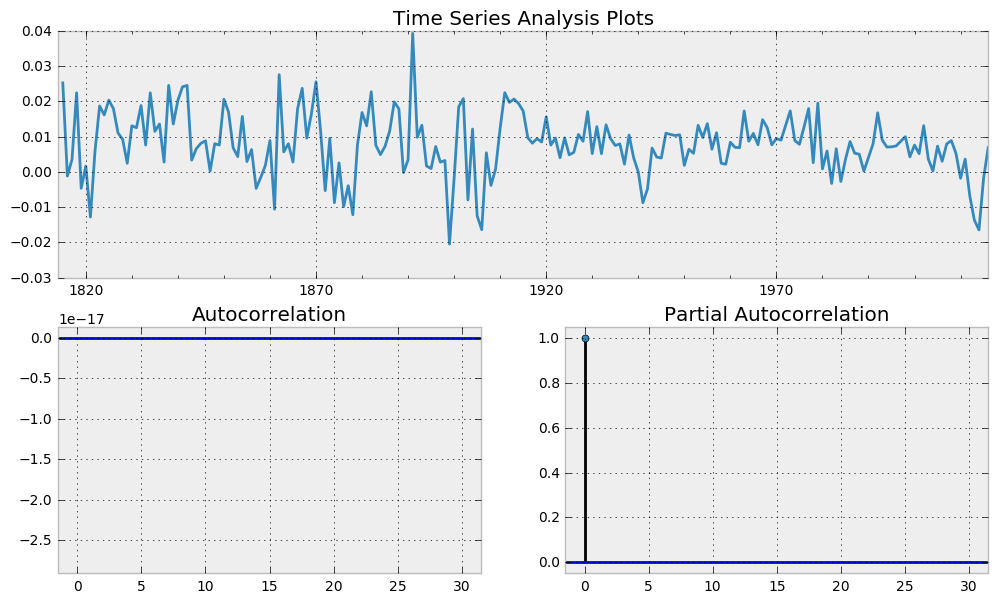

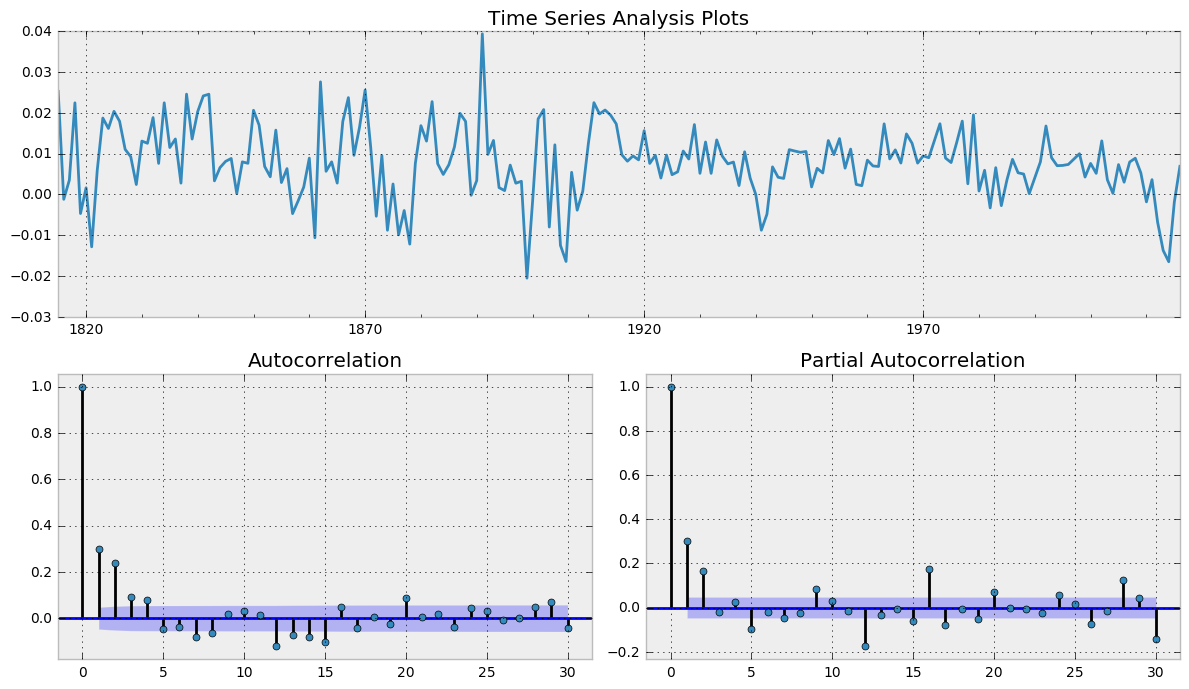

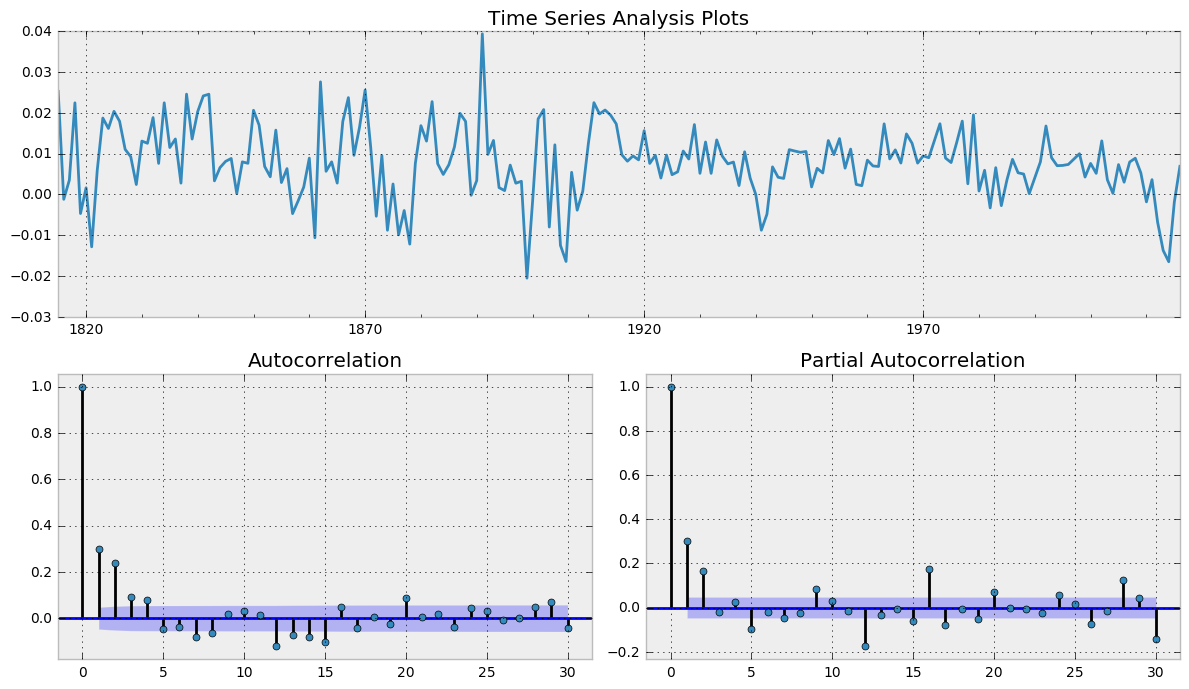

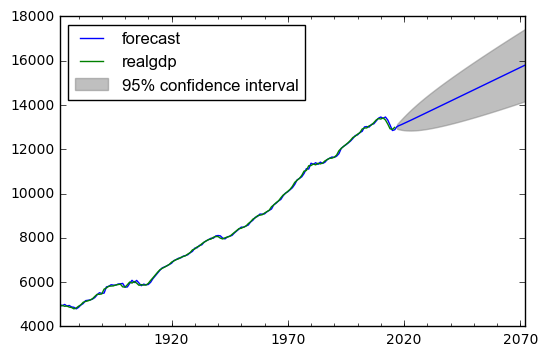

In [36]:

from statsmodels.tsa.arima_model import ARIMA


mod = ARIMA(real_GDP, order=(1,1,1))
res = mod.fit()

res.plot_predict(start='1872-01-01', end='2072-01-01')
plt.show()

Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.

Начальные приближения Q = 1, P = 4, q = 3, p = 4

In [37]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [39]:
%%time
best_model = sm.tsa.statespace.SARIMAX(GDP.GDP_box, order=(4, 1, 3), 
                                        seasonal_order=(4, 1, 1, 24)).fit(disp=-1)
print(best_model.summary())                                        



#model=sm.tsa.statespace.SARIMAX(GDP.GDP_box, order=(param[0], d, param[1]), 
                                        #seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)

/Users/Tatyana/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  203
Model:             SARIMAX(4, 1, 3)x(4, 1, 1, 24)   Log Likelihood                 329.557
Date:                            Thu, 28 Jun 2018   AIC                           -633.113
Time:                                    09:51:17   BIC                           -591.750
Sample:                                         0   HQIC                          -616.339
                                            - 203                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1465      0.529     -0.277      0.782      -1.183       0.890
ar.L2          1.0512      0.477   

Критерий Дики-Фуллера: p=0.000000


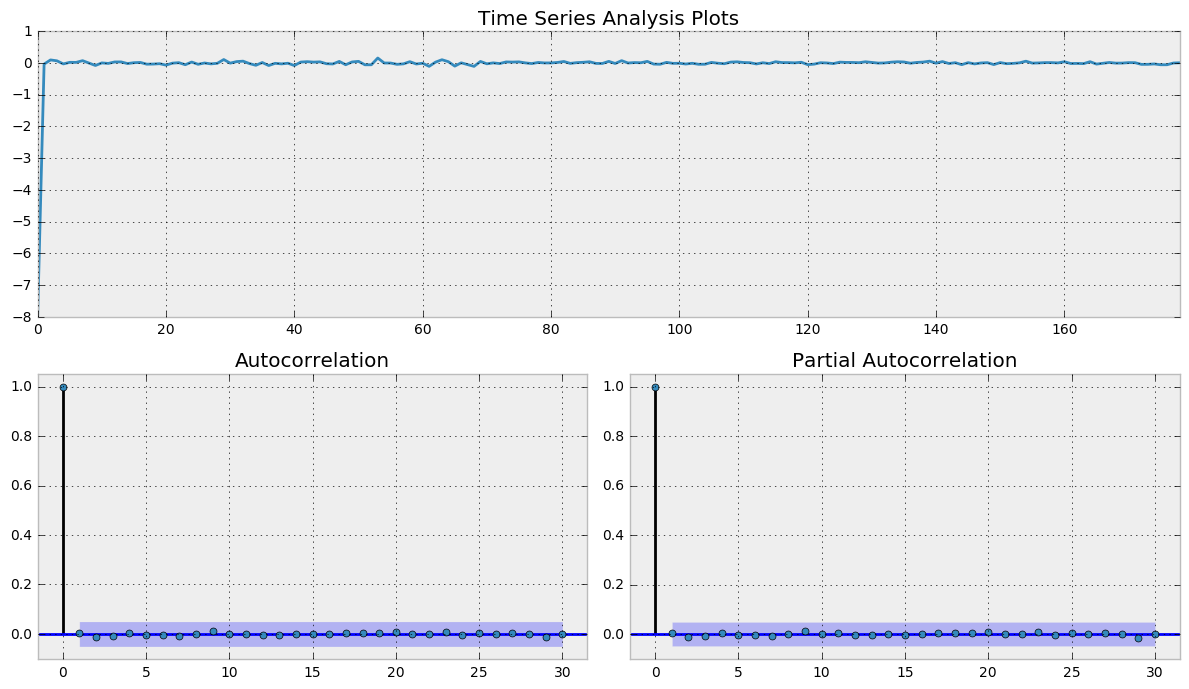

In [40]:
tsplot(best_model.resid[24:], lags=30)
plt.show()

In [41]:
pd.DataFrame(GDP).columns
pd.DataFrame(GDP)

,realgdp
1814-01-01 00:00:00,2710.35
1815-01-01 00:00:00,2778.8
1816-01-01 00:00:00,2775.49
1817-01-01 00:00:00,2785.2
1818-01-01 00:00:00,2847.7
1819-01-01 00:00:00,2834.39
1820-01-01 00:00:00,2839.02
1821-01-01 00:00:00,2802.62
1822-01-01 00:00:00,2819.26
1823-01-01 00:00:00,2872.01


Постараемся не просто установить параметры модели, а подобрать их.

In [46]:
# подбор параметров перебором
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(GDP.GDP_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

SyntaxError: invalid syntax (<ipython-input-46-ae75e0e76667>, line 2)

# VAR

Выразить векторную авторегрессионную модель мы можем довольно простой для понимания формулой

\[y_{t} = c + A_{1}y_{t-1} + ... + A_{p}y_{t-p} + e_{t}\]  

Как мы видим, предсказываемое нами значение временного ряда с некоторым коэффициентом определяется предыдущими значениями и случайной ошибкой. 

In [47]:
mdata = sm.datasets.macrodata.load().data
mdata = mdata[['realgdp','realcons','realinv']]
names = mdata.dtype.names
data = mdata.view((float,3))
data = np.diff(np.log(data), axis=0)
newdata = pd.DataFrame(mdata)

In [48]:
model = VAR(data)
res = model.fit(2)

In [52]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 28, Jun, 2018
Time:                     10:01:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.001527         0.001119            1.365           0.172
L1.y1        -0.279435         0.169663           -1.647           0.100
L1.y2         0.675016         0.131285            5.142           0.000
L1.y3         0.033219

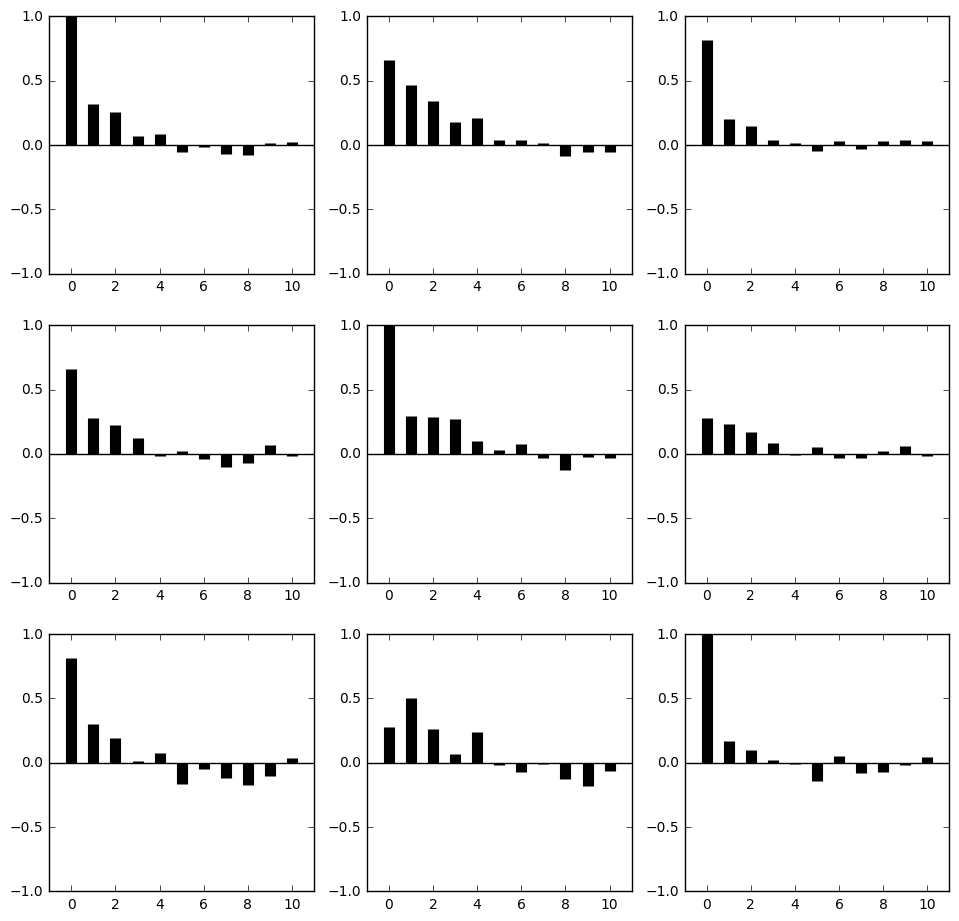

In [44]:
res.plot_sample_acorr()
plt.show()

На этих графиках очень хорошо видно, что автокореляция между наблюдениями затухает на третьем по величине лаге, а затем становится либо отрицательной, либо почти нулевой. А теперь мы выведем на график функции импульсных откликов, чтобы проанализировать, как связаны между собой наши переменные.

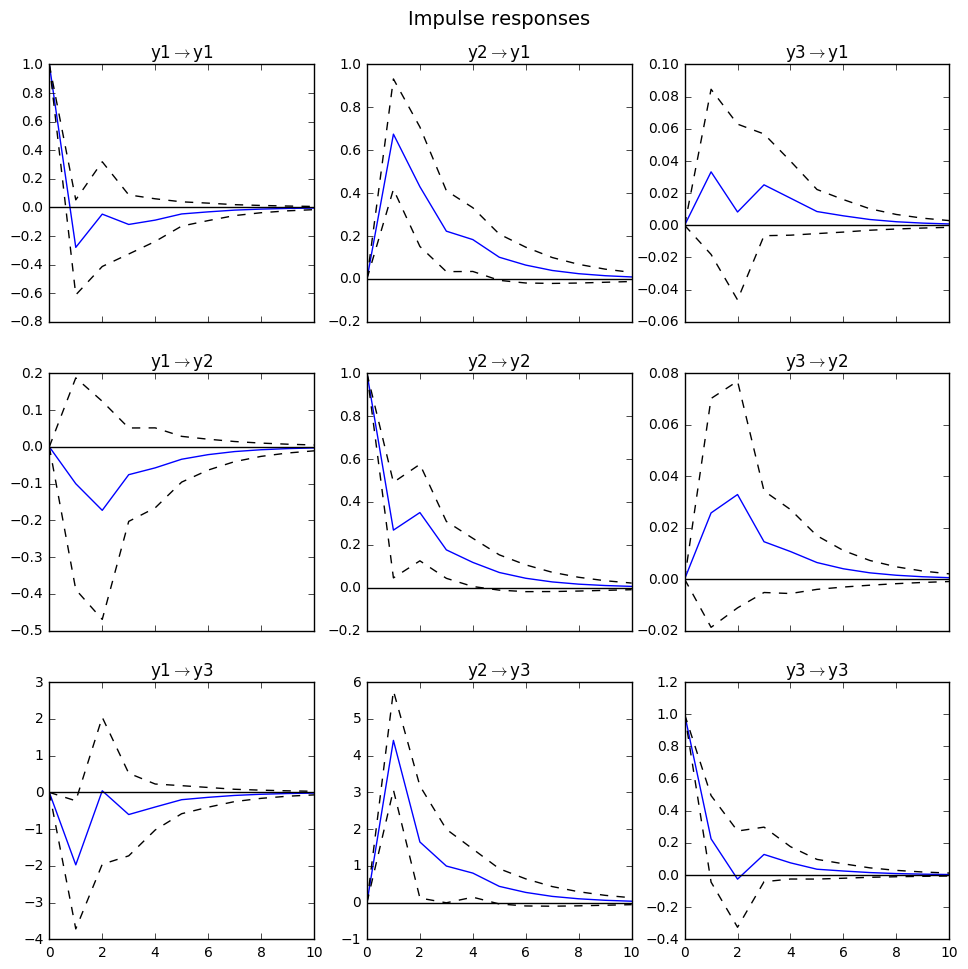

In [45]:
irf = res.irf(10) # 10 periods
irf.plot()
plt.show()

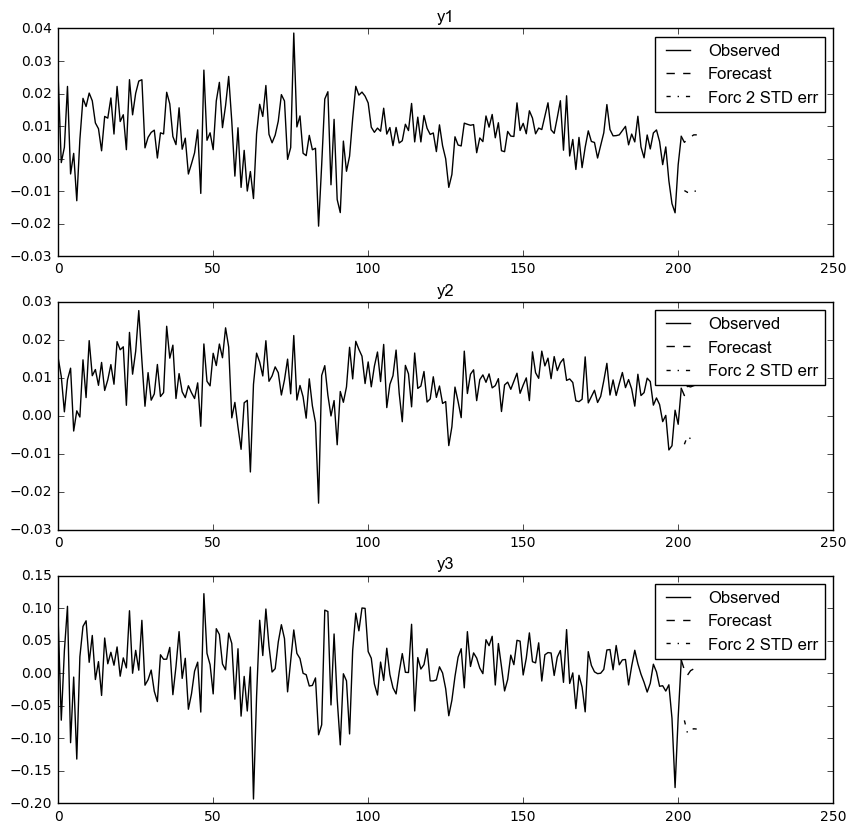

In [46]:
res.plot_forecast(5)
plt.show()

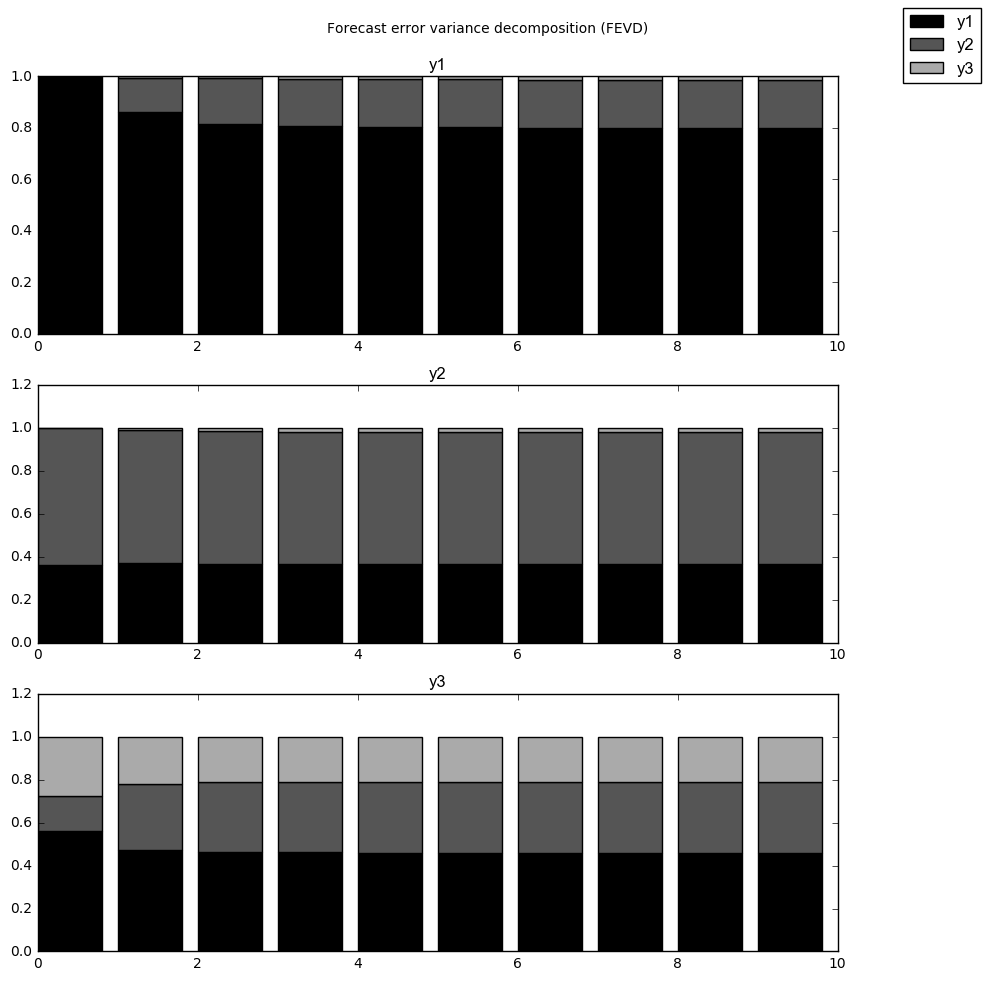

In [47]:
res.fevd().plot()
plt.show()

Трудно сказать, что какая-либо из составляющих перетягивает ошибку на себя, однако видно, что сильнее всего выделяется в декомпозиции ошибки первый столбец.    

По остаткам модель VAR повела себя лучше чем другие и оказалась не менее эффективной.

Чтобы реализовать в качестве априорных предположений для переменных алгоритм черной коробки, Лапласа и Метрополиса-Гастингса, используем библиотеку pyflux и выведем таблицы summary для каждой из вновь получившихся моделей.

import pyflux as pf
model = pf.VAR(data=data, lags=2, integ=1)

print(model.z)


model.list_priors()

model.adjust_prior(2, pf.Normal(0,1))

a = model.fit(method='BBVI', iterations='10000', optimizer='ADAM')

b = model.fit(method='Laplace')

c = model.fit(method='M-H')

Black Box = a.summary()

Laplace = b.summary()

Metropolis_Hastings = c.summary()    


Если вести сравнение по метрике квадрата ошибки, то BVAR показала себя даже хуже чем обычная векторная авторегрессионная модель